#### Development Environment : **Google Colab**
- ref :
https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms/notebook,
https://github.com/quadeer15sh/Flickr8K-Image-Captioning/blob/a3e31d345d5260980a653245c07e492bd4cdfb06/flickr8k-image-captioning-using-cnns-lstms.ipynb
- 추가로 참고할 만한 ref : https://github.com/mybirth0407/show_and_tell_implementation,
https://github.com/solaris33/deep-learning-tensorflow-book-code/blob/master/Ch09-Image_Captioning/im2txt/im2txt/show_and_tell_model.py

## 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

## 2. Google Drive Mounting & Data Loading

In [2]:
# Google Drive Mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# IU X-Ray dataset 불러오기
image_path = 'C:/Users/user02/PycharmProjects/py_37/01_DL_practice/01_Tensorflow_2.x/03_Basic_NIC\show_and_tell_implementation-master/Flickr8k_Dataset'
data = pd.read_csv('/content/drive/MyDrive/colab/OpenDatasets/Flickr8k/Flickr8k_text/captions.txt')

print(data.head())

                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


## 3. Visualization

In [4]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(image_path + "/" + f"{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

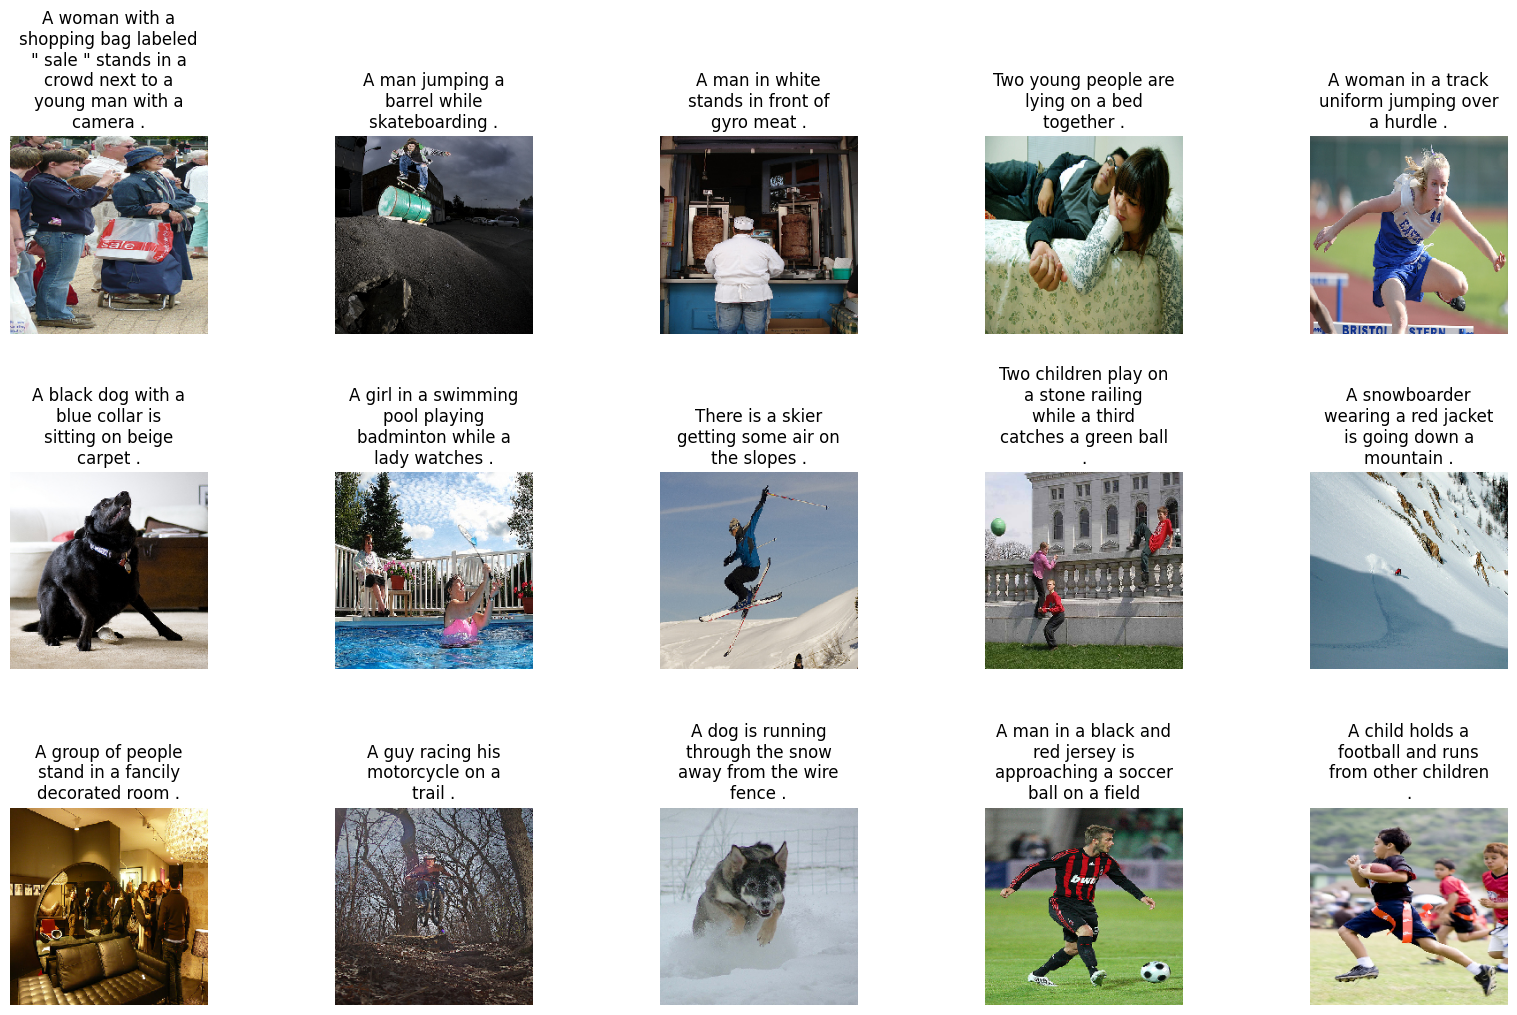

In [5]:
display_images(data.sample(15))

## 4. Text Preprocessing
[Caption Text Preprocessing Steps]
1. Convert sentences into lowercase : 모두 소문자로 변환
2. Remove special characters and numbers present in the text : 문자, 숫자 아닌 기호 제거
3. Remove extra spaces
4. Remove single characters
5. Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [6]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

In [7]:
""" Text Preprocessing """
data = text_preprocessing(data)
captions = data['caption'].tolist()
print(captions[:10])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri-colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


## 5. Tokenization and Encoded Representation
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings
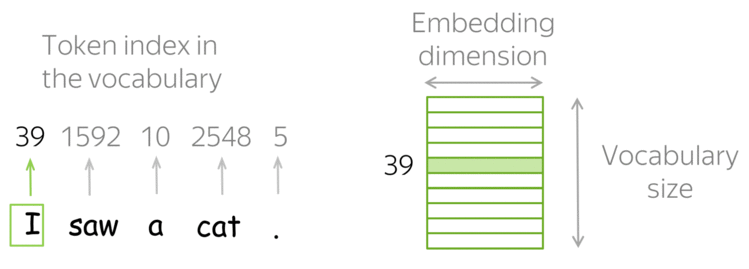

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

print(tokenizer.texts_to_sequences([captions[1]])[0])

[1, 18, 315, 63, 195, 116, 2]


## 6. Image Feature Extraction
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920  
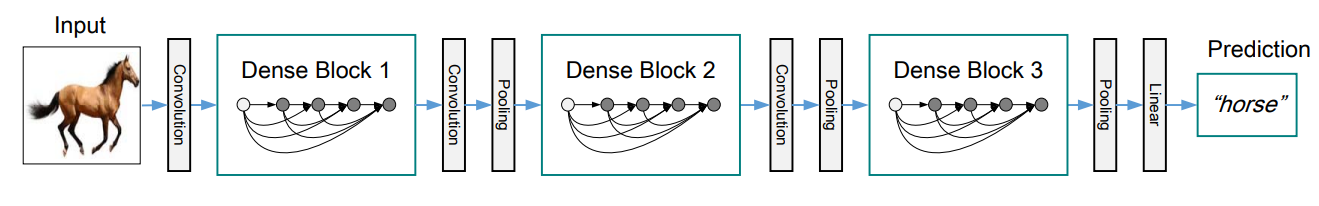

In [9]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature       # vector size : 1920

82524592/82524592 [==============================] - 3s 0us/step


100%|██████████| 8091/8091 [1:19:34<00:00,  1.69it/s]


In [11]:
# features 저장해놓기
# np.save('/content/drive/MyDrive/colab/input_features', features)

## 7. Data Generation
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [15]:
""" Data Generation """
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

## 8. Modelling
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
- The LSTM network starts generating words after each input thus forming a sentence at the end  
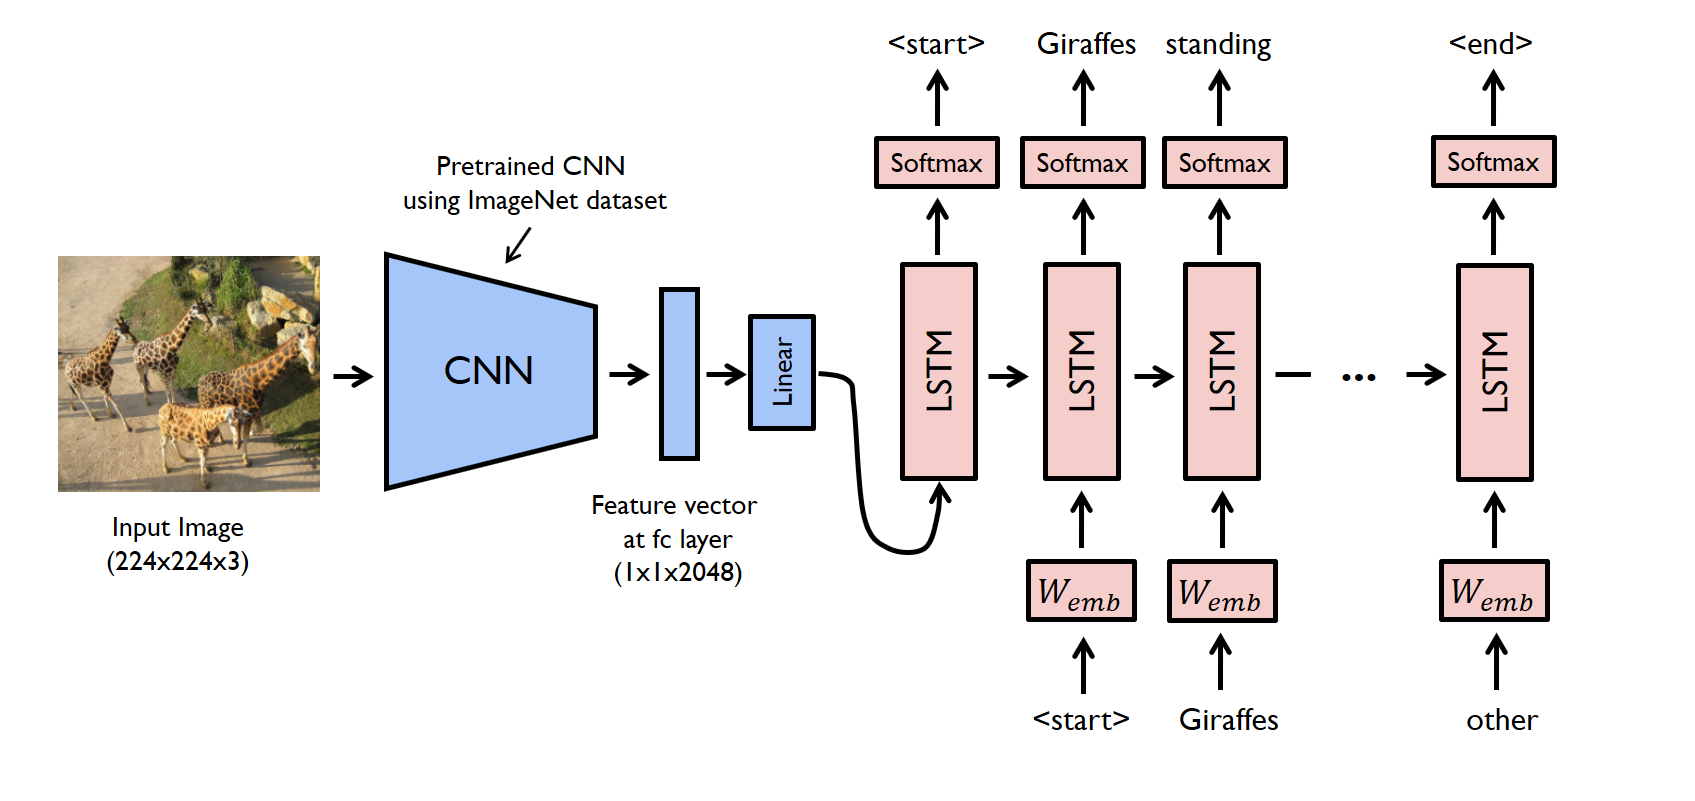

In [16]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

## 9. Model Modification
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: **Show and Tell: A Neural Image Caption Generator** (https://arxiv.org/pdf/1411.4555.pdf)

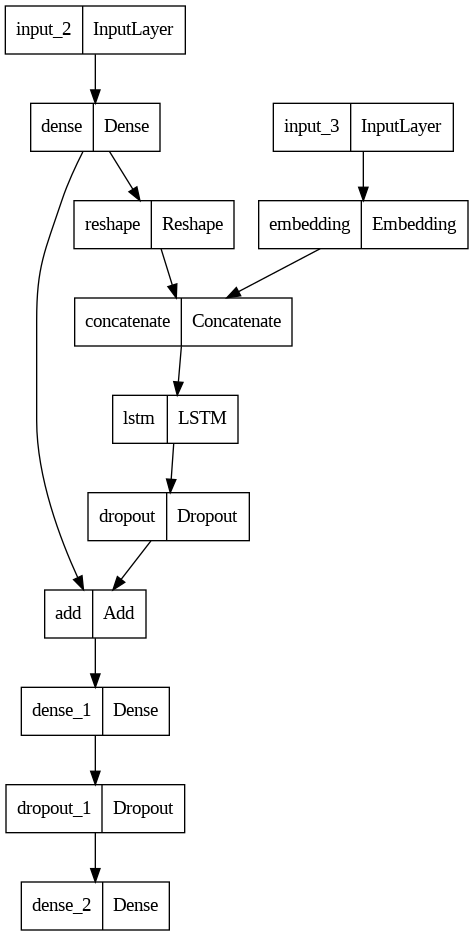

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [18]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  491776    ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                            

## 10. Preparing Generator & Training ST Model

In [19]:
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

In [21]:
model_name = "/content/drive/MyDrive/colab/model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',         # 3번 동안 val_loss 개선 없을 시 lr * 0.2 반복
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [22]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 4.7461
Epoch 1: val_loss improved from inf to 4.14068, saving model to model.h5
537/537 [==============================] - 437s 813ms/step - loss: 4.7461 - val_loss: 4.1407 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


536/537 [============================>.] - ETA: 0s - loss: 4.1061
Epoch 2: val_loss improved from 4.14068 to 3.87089, saving model to model.h5
537/537 [==============================] - 88s 164ms/step - loss: 4.1059 - val_loss: 3.8709 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.8730
Epoch 3: val_loss improved from 3.87089 to 3.75947, saving model to model.h5
537/537 [==============================] - 74s 139ms/step - loss: 3.8730 - val_loss: 3.7595 - lr: 0.0010
Epoch 4/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


537/537 [==============================] - ETA: 0s - loss: 3.7249
Epoch 4: val_loss improved from 3.75947 to 3.69391, saving model to model.h5
537/537 [==============================] - 72s 133ms/step - loss: 3.7249 - val_loss: 3.6939 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 5/50
536/537 [============================>.] - ETA: 0s - loss: 3.6123
Epoch 5: val_loss improved from 3.69391 to 3.65962, saving model to model.h5
537/537 [==============================] - 81s 150ms/step - loss: 3.6121 - val_loss: 3.6596 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 6/50
536/537 [============================>.] - ETA: 0s - loss: 3.5232
Epoch 6: val_loss improved from 3.65962 to 3.63991, saving model to model.h5
537/537 [==============================] - 80s 149ms/step - loss: 3.5232 - val_loss: 3.6399 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 7/50
536/537 [============================>.] - ETA: 0s - loss: 3.4486
Epoch 7: val_loss improved from 3.63991 to 3.62854, saving model to model.h5
537/537 [==============================] - 66s 123ms/step - loss: 3.4484 - val_loss: 3.6285 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8/50
537/537 [==============================] - ETA: 0s - loss: 3.3874
Epoch 8: val_loss did not improve from 3.62854
537/537 [==============================] - 71s 133ms/step - loss: 3.3874 - val_loss: 3.6404 - lr: 0.0010
Epoch 9/50
536/537 [============================>.] - ETA: 0s - loss: 3.3332
Epoch 9: val_loss did not improve from 3.62854
537/537 [==============================] - 70s 130ms/step - loss: 3.3332 - val_loss: 3.6558 - lr: 0.0010
Epoch 10/50
537/537 [==============================] - ETA: 0s - loss: 3.2872
Epoch 10: val_loss did not improve from 3.62854

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
537/537 [==============================] - 75s 140ms/step - loss: 3.2872 - val_loss: 3.6426 - lr: 0.0010
Epoch 11/50
537/537 [==============================] - ETA: 0s - loss: 3.1725
Epoch 11: val_loss did not improve from 3.62854
537/537 [==============================] - 74s 137ms/step - loss: 3.1725 - val_loss: 3.6523 - lr: 2.0000e-

In [23]:
#model.save_weights('/content/drive/MyDrive/colab/model_weights.h5')
#model.load_weights('./01_DL_practice/01_Tensorflow_2.x/02_Basic_NIC/model_weights.h5')

## 11. Inference
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

#### **Learning Curve (Loss Curve)**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
  1. Train the model on a larger dataset Flickr40k
  2. Attention Models

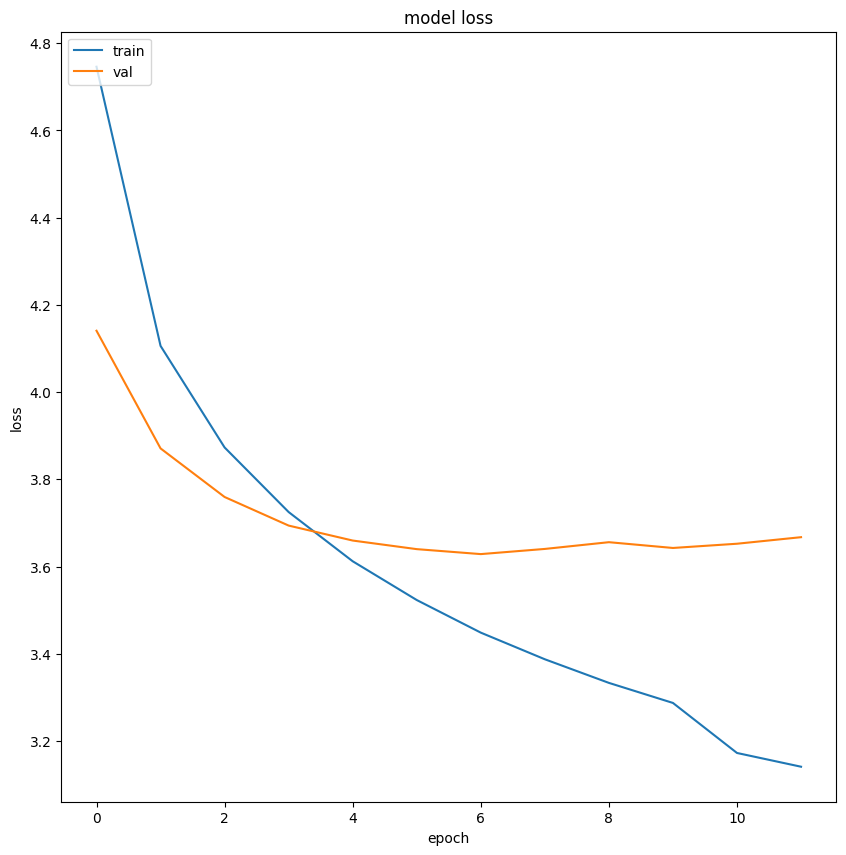

In [24]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 12. Caption Generation Utility Functions
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break

    return in_text

#### **Taking 15 Random Samples for Caption Prediction**

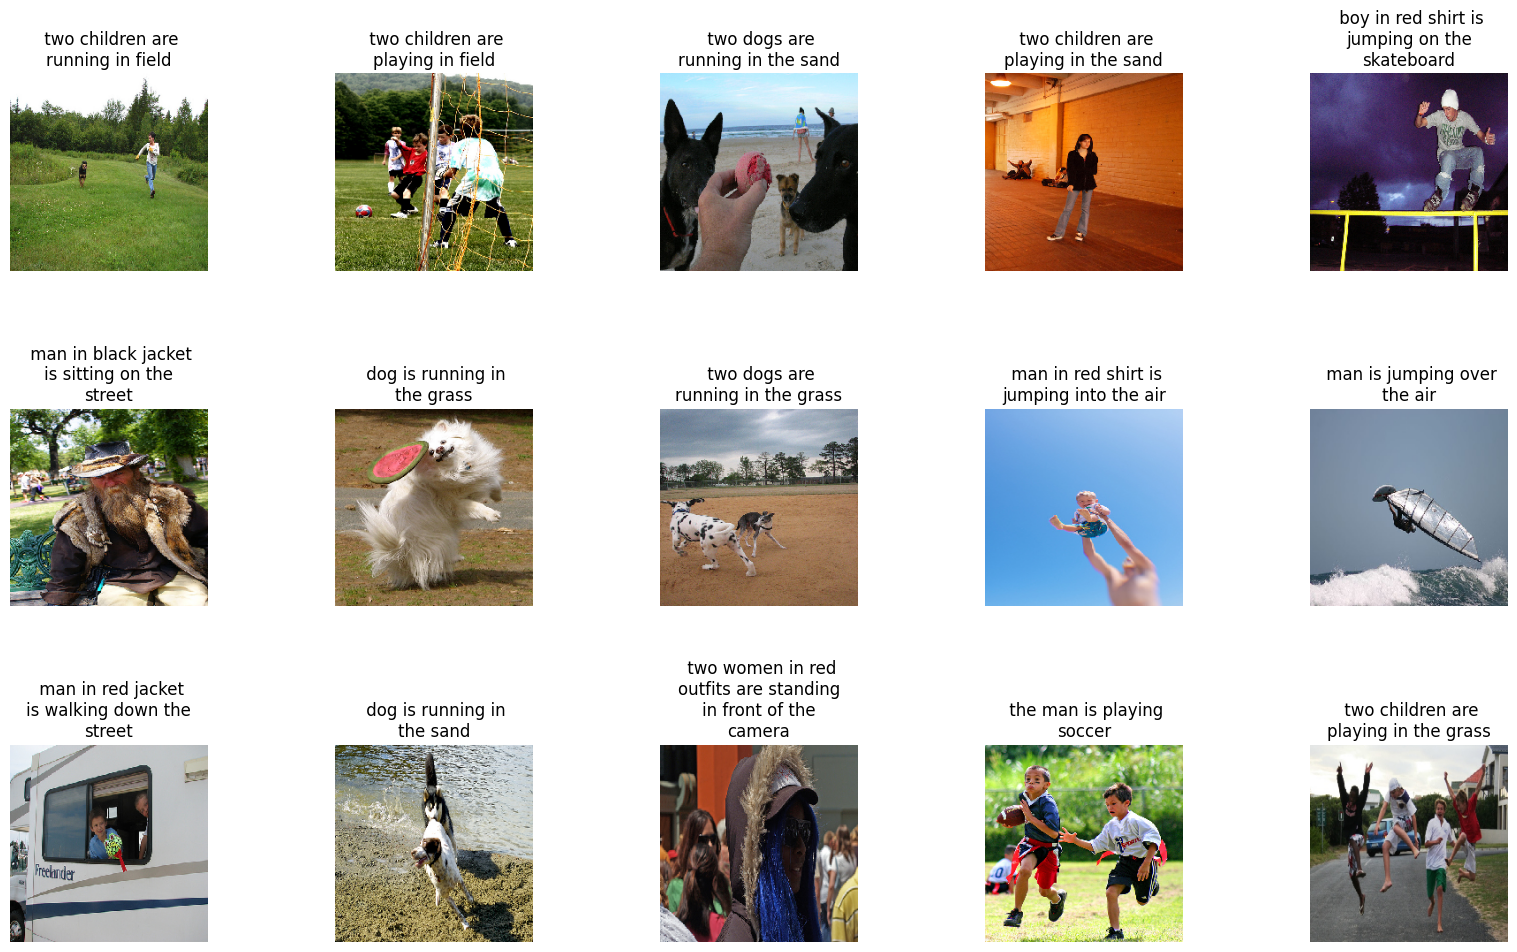

In [28]:
samples = test.sample(15)
samples.reset_index(drop=True, inplace=True)

for index, record in samples.iterrows():
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index, 'caption'] = caption[8:-7]

display_images(samples)

## 13. Results
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

## 14. Conclusion
This may not be the best performing model, but the objective of this kernel is to give a gist of how Image Captioning problems can be approached. In the future work of this kernel Attention model training and BLEU Score assessment will be performed.